In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# change svg font to not be curves
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
import sys
sys.path.append('..')
import eeg_decoder

from rsa_utils import crossnobis

from collections import defaultdict

from os import path

from sklearn.linear_model import LinearRegression

import pickle

from scipy.stats import wilcoxon

from statsmodels.stats.multitest import multipletests

from scipy.stats import rankdata

import pingouin as pg

import json
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
OVERWRITE = False
np.random.seed(42)  # note, this doesn't guarantee perfect reproducibility, due to the parallelization below

In [3]:
time_window = 25 
time_step = 25
n_splits = 1_000

experiment_name = 'data'
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

# just grabbing a random interpreter to use some of its info
interp_coh = eeg_decoder.Interpreter()
interp_coh.load_results('attended_feat')

quad_map = {
    #organized clockwise, starting from top left
    # x, y increasing moving right and down
    (-1, -1): 0,
    (1, -1): 1,
    (1, 1): 2,
    (-1, 1): 3,
}
                # color
cond_order = [110,111,112,113,  # SS1, top left, top right, bottom right, bottom left
              120,121,122,123,  # SS2, top left, top right, bottom right, bottom left
                # motion
              210,211,212,213,  
              220,221,222,223,]  

In [4]:
def str_to_arr(s, sep=' '):
    pieces = s.replace('[', '').replace(']', '').replace(',', '').split(sep)
    return np.array([float(i) for i in pieces])

def get_target_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[:row['SetSize']]))

def get_distractor_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[row['SetSize']:]))

def add_condition_info(beh):
    beh['cond_labels'] = beh['BlockFeature']*100+100  # color = 100, motion = 200
    beh['cond_labels'] += beh['SetSize']*10  # ss1=10, ss2=20
    beh['cond_labels'] += beh.apply(get_target_coherences, axis=1)*1  # coherence = 0, 1, 2

    # add info about the distractor coherence, shown below to be uninformative generally
    beh['full_cond_labels'] =  beh['cond_labels'].values*10 # shift by 1 decimal place
    beh['full_cond_labels'] += beh.apply(get_distractor_coherences, axis=1)  # distractor coherence = 0, 1, 2

    return beh

def get_loc_quad(loc):

    key = (np.sign(loc[0]), np.sign(loc[1]))
    return quad_map[key]

In [5]:
def balance_data(X_train, y_train, X_test, y_test):
    min_count = min(min(np.unique(y_train, return_counts=True)[1]), min(np.unique(y_test, return_counts=True)[1]))

    balanced_X_train = np.full((len(np.unique(y_train))*min_count, X_train.shape[1], X_train.shape[2]), np.nan)
    balanced_y_train = np.full(len(np.unique(y_train))*min_count, np.nan)
    balanced_X_test = np.full((len(np.unique(y_test))*min_count, X_test.shape[1], X_test.shape[2]), np.nan)
    balanced_y_test = np.full(len(np.unique(y_test))*min_count, np.nan)

    for i, cond in enumerate(np.unique(y_train)):
        # one option is to shuffle the indices and take the first min_count. 
        # However, the sklearn func has already shuffled the trial order for us
        train_idx = np.where(y_train == cond)[0]
        balanced_X_train[i*min_count:(i+1)*min_count] = X_train[train_idx[:min_count]]
        balanced_y_train[i*min_count:(i+1)*min_count] = [cond]*min_count

        test_idx = np.where(y_test == cond)[0]
        balanced_X_test[i*min_count:(i+1)*min_count] = X_test[test_idx[:min_count]]
        balanced_y_test[i*min_count:(i+1)*min_count] = [cond]*min_count

    balanced_y_train = [int(i) for i in balanced_y_train]
    balanced_y_test = [int(i) for i in balanced_y_test]
    return balanced_X_train, balanced_y_train, balanced_X_test, balanced_y_test

In [6]:
if OVERWRITE:
    cond_accs = {}
    for isub in range(exp.nsub):
        sub_file_out = f'output/rdms/sub_{isub}_spatial.npy'
        print(f'Computing RDMs for sub {isub}...')

        xdata,_ = exp.load_eeg(isub)
        beh = pd.DataFrame(exp.load_behavior(isub))

        first_loc = beh.TestLocation.apply(lambda x: json.loads(x)) # used for SS 1
        last_loc = beh.Locations.apply(lambda x: json.loads(x)[2])  # used for SS 2
        first_quad = first_loc.apply(get_loc_quad).values
        last_quad = last_loc.apply(get_loc_quad).values
        beh['Quad'] = np.where(beh.SetSize == 1, first_quad, last_quad)
        beh['Cond'] = beh['BlockFeature']*100+100 + beh['SetSize']*10 + beh['Quad']
        ydata = beh['Cond'].values

        # get condition level accuracy to add as a nuisance regressor
        cond_accs[isub] = beh.groupby('Cond').mean().loc[cond_order, 'ACC']


        # compress xdata to same time windows as decoding
        xdata_binned = np.full((xdata.shape[0], xdata.shape[1], len(interp_coh.t)), np.nan)
        for i, bin_start in enumerate(interp_coh.t):
            if i < len(interp_coh.t)-1:
                window_idx = (exp.info['times'] >= bin_start) & (exp.info['times'] < interp_coh.t[i+1])
            else:
                window_idx = (exp.info['times'] >= bin_start)
            xdata_binned[:, :, i] = xdata[:, :, window_idx].mean(2)

        sub_rdms = crossnobis(xdata_binned, ydata, cond_order, n_splits=n_splits, balance_func=balance_data)
        np.save(sub_file_out, sub_rdms)

    with open('output/beh_accs_spatial.pkl', 'wb') as f:
        pickle.dump(cond_accs, f)

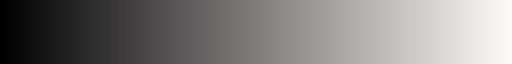

In [7]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'snow'])
cmap

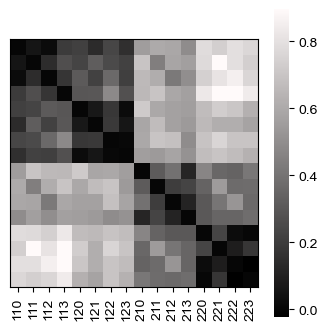

In [8]:
avg_RDM = np.zeros((len(cond_order), len(cond_order)))
for isub in range(exp.nsub):
    sub_file = f'output/rdms/sub_{isub}_spatial.npy'
    sub_rdms = np.load(sub_file)
    avg_RDM += sub_rdms[:,:,interp_coh.t > 500].mean(2)  # average across the delay period

avg_RDM /= exp.nsub
plt.figure(figsize=(4, 4))
ax = sns.heatmap(avg_RDM, xticklabels=cond_order, yticklabels=[], square=True, cmap=cmap, cbar=True) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.savefig(f'output/figures/RDM_empirical_spatial.svg')
plt.show()
plt.close()

In [9]:
sub_rdms.shape

(16, 16, 70)

In [10]:
same_hemis = [(0,3), (1,2)]
cross_hemi = [(0,1), (2,3)]
opposites = [(0,2), (1,3)]

conditions = [11, 12, 21, 22]
cond_map = {
    11: 'Color_SS1',
    12: 'Color_SS2',
    21: 'Motion_SS1',
    22: 'Motion_SS2',

}

res_dict = defaultdict(list)

for isub in range(exp.nsub):
    sub_file = f'output/rdms/sub_{isub}_spatial.npy'
    sub_rdms = np.load(sub_file)

    for i,cond in enumerate(conditions):
        cond_rdm = sub_rdms[(i*4):(i*4+4), (i*4):(i*4+4), interp_coh.t > 500].mean(2)

        same_hemi = cond_rdm[[0, 1], [3, 2]].mean()
        cross_hemi = cond_rdm[[0, 2], [1, 3]].mean()
        opposite = cond_rdm[[0, 1], [2, 3]].mean()

        res_dict['Condition'].append(cond_map[cond])
        res_dict['Same Hemisphere'].append(same_hemi)
        res_dict['Cross Hemisphere'].append(cross_hemi)
        res_dict['Opposite Diagonal'].append(opposite)
        res_dict['Average'].append(np.triu(cond_rdm).sum()/6)
        res_dict['Subject'].append(isub)
        


In [11]:
delay_res = pd.DataFrame(res_dict).melt(id_vars=['Condition', 'Subject'], var_name='Distance', value_name='Dissimilarity')

In [12]:
delay_res

,Condition,Subject,Distance,Dissimilarity
0,Color_SS1,0,Same Hemisphere,0.237652
1,Color_SS2,0,Same Hemisphere,-0.148932
2,Motion_SS1,0,Same Hemisphere,0.220430
3,Motion_SS2,0,Same Hemisphere,0.106836
4,Color_SS1,1,Same Hemisphere,-0.031302
...,...,...,...,...
251,Motion_SS2,14,Average,0.276680
252,Color_SS1,15,Average,0.220489
253,Color_SS2,15,Average,-0.173829
254,Motion_SS1,15,Average,0.304268


<Axes: xlabel='Distance', ylabel='Dissimilarity'>

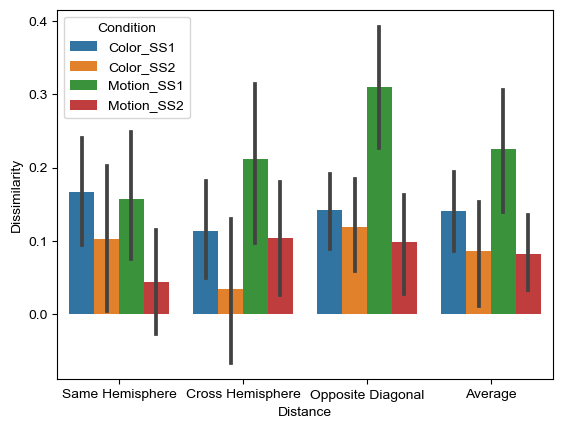

In [13]:
sns.barplot(data=delay_res, x='Distance', y='Dissimilarity', hue='Condition')

In [14]:
conditions = [11, 12, 21, 22]
cond_map = {
    11: 'Color SS1 Target',
    12: 'Color SS2 Placeholder',
    21: 'Motion SS1 Target',
    22: 'Motion SS2 Placeholder',

}

res_dict = defaultdict(list)

for isub in range(exp.nsub):
    sub_file = f'output/rdms/sub_{isub}_spatial.npy'
    sub_rdms = np.load(sub_file)

    for i,cond in enumerate(conditions):
        cond_rdm_full_time = sub_rdms[(i*4):(i*4+4), (i*4):(i*4+4)]
        for t in range(cond_rdm_full_time.shape[-1]):
            cond_rdm = cond_rdm_full_time[:,:,t]

            res_dict['Condition'].append(cond_map[cond])
            res_dict["Spatial Decodability (d')"].append(np.triu(cond_rdm).sum()/6)
            res_dict['Subject'].append(isub)
            res_dict['Timepoint'].append(interp_coh.t[t])
            


In [15]:
time_res = pd.DataFrame(res_dict)
time_res = time_res.assign(  # useful for setting up ANOVA below
    attended_feature = lambda x: x.Condition.apply(lambda x: x.split(' ')[0]),
    set_size = lambda x: x.Condition.apply(lambda x: x.split(' ')[1])
)
time_res

,Condition,Spatial Decodability (d'),Subject,Timepoint,attended_feature,set_size
0,Color SS1 Target,0.110549,0,-200,Color,SS1
1,Color SS1 Target,0.058034,0,-176,Color,SS1
2,Color SS1 Target,-0.272280,0,-152,Color,SS1
3,Color SS1 Target,-0.028990,0,-128,Color,SS1
4,Color SS1 Target,0.016390,0,-104,Color,SS1
...,...,...,...,...,...,...
4475,Motion SS2 Placeholder,-0.076100,15,1360,Motion,SS2
4476,Motion SS2 Placeholder,-0.124587,15,1384,Motion,SS2
4477,Motion SS2 Placeholder,-0.019080,15,1408,Motion,SS2
4478,Motion SS2 Placeholder,0.160765,15,1432,Motion,SS2


In [16]:
# at each time point, check whether each condition's slope is significantly different from 0
test_dict = defaultdict(list)
anova_dict = defaultdict(list)
for t in interp_coh.t:
    time_res_t = time_res.query(f'Timepoint == {t}')

    anova_res = pg.rm_anova(data=time_res_t, dv="Spatial Decodability (d')", within=['attended_feature', 'set_size'], subject='Subject')
    for c,anova_cond in enumerate(['attended_feature', 'set_size', 'attended_feature * set_size']):
        anova_dict['Condition'].append(anova_cond)
        anova_dict['Timepoint'].append(t)
        anova_dict['F'].append(anova_res['F'].values[c])
        anova_dict['p-value'].append(anova_res['p-unc'].values[c])

    for cond in time_res_t.Condition.unique():
        cond_res = time_res_t.query(f'Condition == "{cond}"')
        [t_score, p] = pg.ttest(cond_res["Spatial Decodability (d')"], 0, alternative="greater").loc[:, ['T', 'p-val']].values[0]
        test_dict['Condition'].append(cond)
        test_dict['Timepoint'].append(t)
        test_dict['p-value'].append(p)

    
anova_df = pd.DataFrame(anova_dict)
test_df = pd.DataFrame(test_dict)

In [17]:
anova_res = pg.rm_anova(data=time_res_t, dv="Spatial Decodability (d')", within=['attended_feature', 'set_size'], subject='Subject')

anova_res.loc[2, 'p-unc']  #2x2 always spherical

0.6524407659369988

In [18]:
palette = {
'Color SS1 Target': 'sienna',
'Color SS2 Placeholder': 'gold',
'Motion SS1 Target': 'darkgreen',
'Motion SS2 Placeholder': 'lime',
'attended_feature': 'tab:blue',
'set_size': 'tab:red',
'attended_feature * set_size': 'black',
}

Color SS1 Target 32
[ 100.5  124.5  148.5  172.5  196.5  220.5  244.5  268.5  292.5  316.5
  340.5  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5
  580.5  604.5  628.5  652.5  676.5  700.5  724.5  748.5  796.5 1084.5
 1108.5 1156.5]
Color SS2 Placeholder 24
[148.5 172.5 196.5 316.5 340.5 364.5 388.5 436.5 460.5 484.5 508.5 532.5
 556.5 580.5 604.5 628.5 652.5 700.5 724.5 772.5 796.5 820.5 844.5 892.5]
Motion SS1 Target 39
[ 100.5  124.5  148.5  172.5  196.5  220.5  244.5  268.5  292.5  316.5
  340.5  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5
  580.5  604.5  628.5  652.5  676.5  700.5  724.5  748.5  772.5  796.5
  820.5  844.5  868.5  892.5  916.5 1012.5 1036.5 1084.5 1108.5]
Motion SS2 Placeholder 27
[172.5 196.5 220.5 244.5 268.5 292.5 316.5 340.5 364.5 388.5 412.5 436.5
 460.5 484.5 508.5 532.5 556.5 580.5 604.5 628.5 652.5 676.5 700.5 724.5
 748.5 772.5 796.5]
attended_feature 6
[412.5 508.5 628.5 652.5 676.5 700.5]
set_size 28
[-187.5  100.5  124

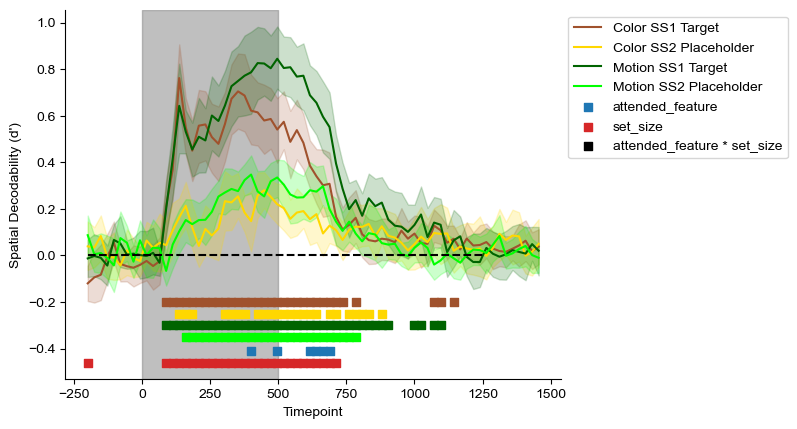

In [19]:
ax = sns.lineplot(data=time_res, x='Timepoint', y="Spatial Decodability (d')", hue='Condition', palette=palette)

# add horizontal line at 0
# _ = ax.axhline(0, -200, 1500, color='black', linestyle='--')
plt.hlines(0, -200, 1250, color='black', linestyle='--')

for i,cond in enumerate(time_res.Condition.unique()):
    p_vals = test_df.query(f'Condition == "{cond}"')['p-value'].values

    _, corrected_p, _, _ = multipletests(p_vals, method='fdr_bh')
    sig05 = corrected_p < .05
    print(cond, sig05.sum())
    print(interp_coh.t[sig05]+12.5)

    plt.scatter(x=interp_coh.t[sig05], y=[-.2-.05*i]*sig05.sum(), marker='s', facecolor=palette[cond])

for c, anova_cond in enumerate(anova_df.Condition.unique()):
    p_vals = anova_df.query(f'Condition == "{anova_cond}"')['p-value'].values
    _, corrected_p, _, _ = multipletests(p_vals, method='fdr_bh')
    sig05 = corrected_p < .05
    print(anova_cond, sig05.sum())
    print(interp_coh.t[sig05]+12.5)

    plt.scatter(x=interp_coh.t[sig05], y=[-.41-.05*c]*sig05.sum(), marker='s', color=palette[anova_cond], label=anova_cond)

sns.despine()
_ = plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ylim = plt.ylim()
plt.fill_between([0, 500], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.5, zorder=-1)
plt.ylim(ylim)
plt.savefig('output/figures/spatial_decodability.svg')

# one sided t-test of SS1 vs SS2
### as you can see below, it really just adds one timepoint ~1100ms, that is isolated from the rest

In [20]:
p_vals = []
for t in interp_coh.t:
    time_res_t = time_res.query(f'Timepoint == {t}')

    color_SS1 = time_res_t.query('attended_feature == "Color" and set_size == "SS1"')["Spatial Decodability (d')"].values
    color_SS3 = time_res_t.query('attended_feature == "Color" and set_size == "SS2"')["Spatial Decodability (d')"].values
    motion_SS1 = time_res_t.query('attended_feature == "Motion" and set_size == "SS1"')["Spatial Decodability (d')"].values
    motion_SS3 = time_res_t.query('attended_feature == "Motion" and set_size == "SS2"')["Spatial Decodability (d')"].values

    SS1 = color_SS1 + motion_SS1
    SS3 = color_SS3 + motion_SS3
    # 
    p_vals.append(pg.ttest(SS1, SS3, paired=True, alternative='greater').loc['T-test', 'p-val'])

# correct for multiple comparisons
_, corrected_p, _, _ = multipletests(p_vals, method='fdr_bh')
sig05 = corrected_p < .05
print(sig05.sum())
print(interp_coh.t[sig05])

29
[  88  112  136  160  184  208  232  256  280  304  328  352  376  400
  424  448  472  496  520  544  568  592  616  640  664  688  712  736
 1072]
